In [8]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

In [20]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

X_dim = X_train.shape[1]
y_dim = y_train.shape[1]

X_train = X_train.reshape(ntrain,X_dim)
X_test = X_test.reshape(ntest,X_dim)

y_train = y_train.reshape(ntrain,16,16,1)
y_test = y_test.reshape(ntest,16,16,1)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('training data: measurements', X_train.shape, 'solution', y_train.shape)
print('training data: measurements', X_test.shape, 'solution', y_test.shape)

training data: measurements torch.Size([8000, 128]) solution torch.Size([8000, 16, 16, 1])
training data: measurements torch.Size([2000, 128]) solution torch.Size([2000, 16, 16, 1])


In [10]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [11]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

width = 64
modes = 5


weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [12]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        print('bixy,ioxy->boxy: input is', input.shape, 'weights are', weights.shape)
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)
        print('before FFT',x.shape,'after FFT',x_ft.shape)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [21]:
class FNO2d_edit(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d_edit, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic

        self.fc00 = nn.Linear(8*16, 16*16)
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        #print('shape before concat', x.shape)
        x = self.fc00(x)
        x = x.reshape(x.shape[0],16,16,1)

        
        x = self.fc0(x)
        #print('shape after concat', x.shape)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [14]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

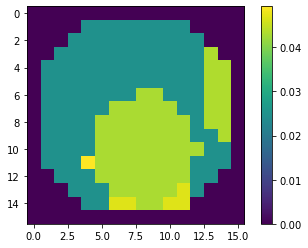

In [15]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [22]:
# SIGMA - TEST NETWORK
############################################################################

model_fcn_sigma = FNO2d_edit(modes, modes, width).cuda()
print(count_params(model_fcn_sigma))
output_sigma = train_model(model_fcn_sigma, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_sigma = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

1696769


IndexError: tuple index out of range